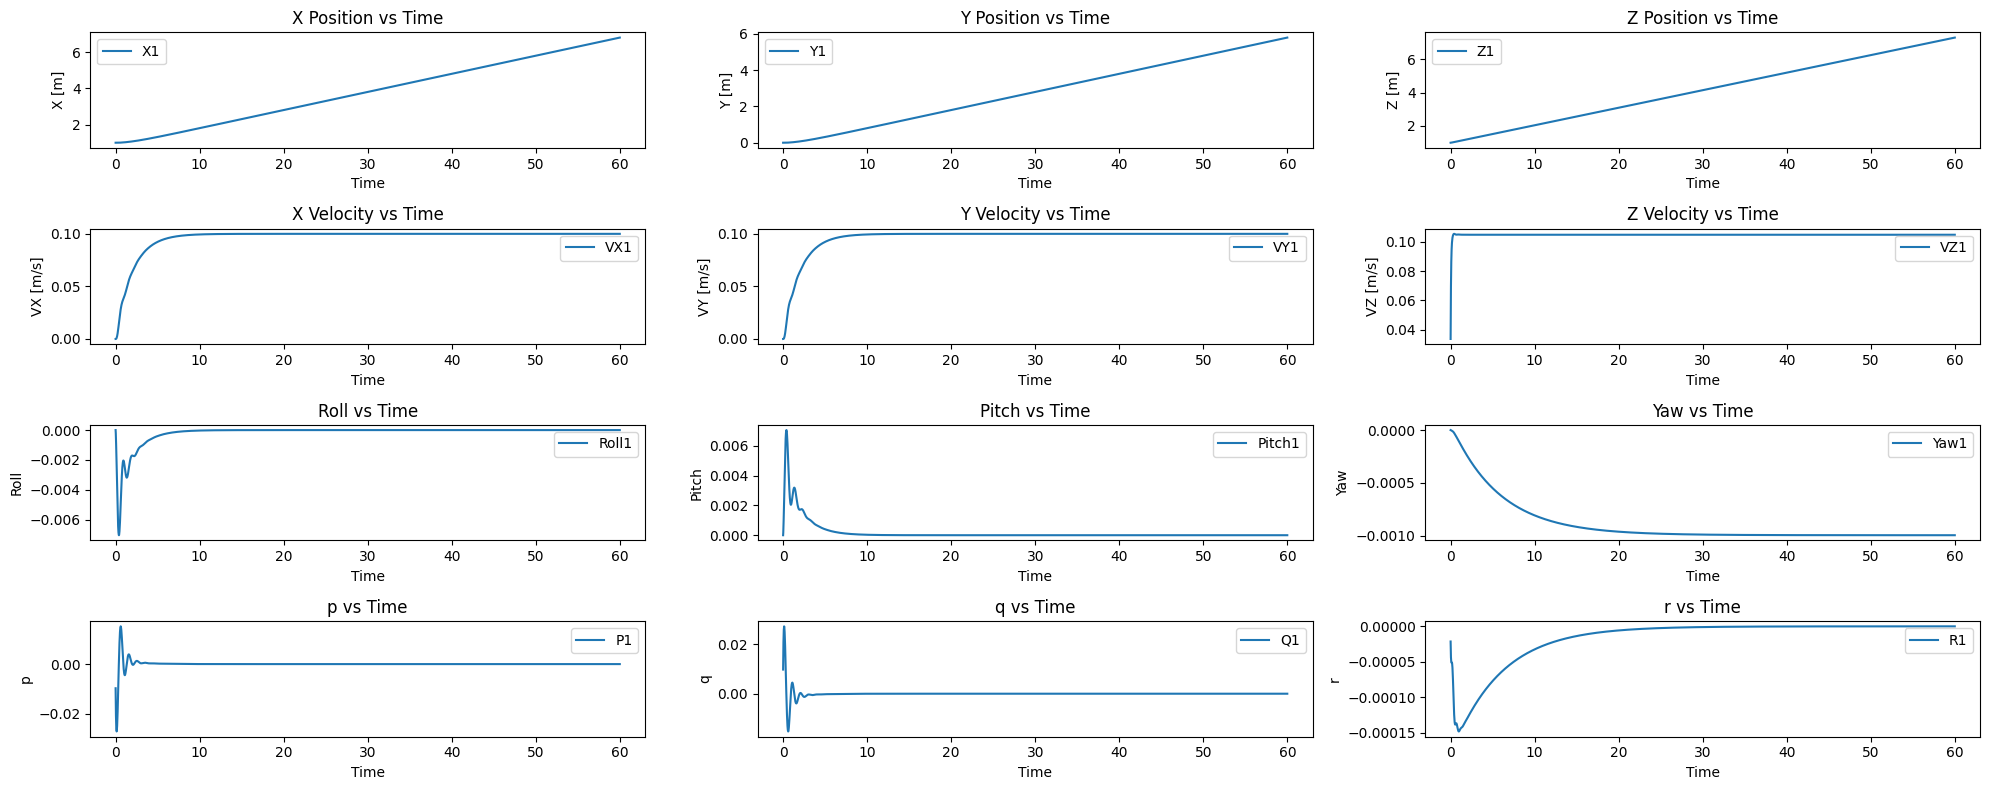

In [2]:
import numpy as np
import matplotlib.pyplot as plt
    
class Simulation:
    def __init__(self):
        # Define Desired Velocities
        vx_ref1 = 0.1
        vy_ref1 = 0.1 
        vz_ref1 = 0.1
        yaw_rate_ref = 0

        # Quadcopter 1
        self.pid_vz1 = PID(kp_vz, ki_vz, kd_vz, vz_lim, vz_ref1) 
        self.pid_yaw_rate1 = PID(kp_yaw_rate, ki_yaw_rate, kd_yaw_rate, yaw_rate_lim, yaw_rate_ref)
        self.pid_vx1 = PID(kp_vx, ki_vx, kd_vx, vx_lim, vx_ref1)
        self.pid_vy1 = PID(kp_vy, ki_vy, kd_vy, vy_lim, vy_ref1)

    def run_iteration(self, pos_1, vel_1, att_1, pqr_1, dt):
        # Quadcopter 1
        thrust_PWM = self.pid_vz1.compute(vel_1[2], dt) 
        yaw_PWM = self.pid_yaw_rate1.compute(pqr_1[2], dt)
        
        out_vx1 = self.pid_vx1.compute(vel_1[0], dt)
        out_vy1 = self.pid_vy1.compute(vel_1[1], dt)
        roll_des = np.clip(((-np.sin(att_1[2]) * out_vx1) + (np.cos(att_1[2]) * out_vy1)), -3, 3)
        pitch_des = np.clip(((np.cos(att_1[2]) * out_vx1) + (np.sin(att_1[2]) * out_vy1)), -3, 3)

        pid_roll1 = PID(kp_roll, ki_roll, kd_roll, roll_lim, roll_des)
        pid_pitch1 = PID(kp_pitch, ki_pitch, kd_pitch, pitch_lim, pitch_des)

        pid_roll1.setpoint = roll_des


        roll_rate_des = pid_roll1.compute(att_1[0], dt)
        pitch_rate_des = pid_pitch1.compute(att_1[1], dt)
        pid_roll_rate1 = PID(kp_roll_rate, ki_roll_rate, kd_roll_rate, roll_rate_lim, roll_rate_des)
        pid_pitch_rate1 = PID(kp_pitch_rate, ki_pitch_rate, kd_pitch_rate, pitch_rate_lim, pitch_rate_des)
        roll_PWM = pid_roll_rate1.compute(pqr_1[0], dt)
        pitch_PWM = pid_pitch_rate1.compute(pqr_1[1], dt)
        dist = PowerDistribution()
        motor_pwm = dist.compute(roll_PWM, pitch_PWM, yaw_PWM, thrust_PWM)
        conv = PWMConversion()
        u_dyn = conv.compute(motor_pwm, dt)
        quadcopter = Quadcopter(pos_1, vel_1, att_1, pqr_1)
        pos_1, vel_1, att_1, pqr_1 = quadcopter.compute(u_dyn, dt)
        return pos_1, vel_1, att_1, pqr_1
    
    def PowerDistribution():
        return
    
class Quadcopter:
    def __init__(self, pos_1, vel_1, att_1, pqr_1):
        self.state = np.concatenate((pos_1, att_1, vel_1, pqr_1))
    def compute(self, u, dt):
        A = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 9.81, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, -9.81, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        B = np.array([[0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 28.57],
                      [0.001802, -0.001802, -0.001802, 0.001802, 0],
                      [0.001802, 0.001802, -0.001802, -0.001802, 0],
                      [3.417e-5, -3.417e-5, 3.417e-5, -3.417e-5, 0]])
        C = np.eye(12)
        D = np.zeros((12, 5))
        xdot = self.state + (np.dot(A, self.state) + np.dot(B, u))*dt
        pos_1 = xdot[:3]
        att_1 = xdot[3:6]
        vel_1 = xdot[6:9]
        pqr_1 = xdot[9:]
        return pos_1, vel_1, att_1, pqr_1
    
class PWMConversion:
    def __init__(self):
        pass
    def compute(self, motor_pwms, dt):
        omega_4m = self.pwm2omega(motor_pwms, dt)
        omega_1 = omega_4m[0]
        omega_2 = omega_4m[1]
        omega_3 = omega_4m[2]
        omega_4 = omega_4m[3]
        thrust_4m = self.pwm2thrust(motor_pwms)
        u_dyn = np.array((omega_1, omega_2, omega_3, omega_4, thrust_4m))
        return u_dyn
    def pwm2omega(self, motor_pwms, dt):
        p = [0.03950236, 420.9420]
        omegas = (np.polyval(p, motor_pwms)) * dt
        omegas_sq = np.square(omegas)
        return omegas_sq
    def pwm2thrust(self, motor_pwms):
        p = [2.130295e-11, 1.032633e-6, 5.484560e-04]
        thrusts = np.polyval(p, motor_pwms)
        thrust_sum = np.sum(thrusts)
        return thrust_sum

class PowerDistribution:
    def __init__(self):
        pass
    def compute(self, roll, pitch, yaw, thrust):
        motor1_pwm = thrust - roll - pitch + yaw
        motor2_pwm = thrust + roll - pitch - yaw
        motor3_pwm = thrust + roll + pitch + yaw
        motor4_pwm = thrust - roll + pitch - yaw
        motor_pwms = np.array([motor1_pwm, motor2_pwm, motor3_pwm, motor4_pwm])
        return motor_pwms

class PID:
    def __init__(self, kp, ki, kd, limit, ref):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.int_limit = limit
        self.setpoint = ref
        self.error = 0
        self.prev_error = 0
        self.int_error = 0
        self.der_error = 0
        self.output = 0
    def compute(self, state, dt):
        self.error = self.setpoint - state
        self.int_error += np.clip((self.error * dt), -self.int_limit, self.int_limit)
        self.der_error = (self.error - self.prev_error) / dt 
        self.prev_error = self.error
        self.output = self.kp * self.error + self.ki * self.int_error + self.kd * self.der_error
        return self.output
    
def compute_jacobians(quadcopter, state, input, dt):
    n_states = len(state)
    n_inputs = len(input)

    # Initialize Jacobians
    A = np.zeros((n_states, n_states))
    B = np.zeros((n_states, n_inputs))

    # Perturbation for numerical differentiation
    perturbation = 1e-6

    # Calculate A matrix
    for i in range(n_states):
        state_plus = np.copy(state)
        state_minus = np.copy(state)
        state_plus[i] += perturbation
        state_minus[i] -= perturbation

        # Calculate the state derivatives for perturbed states
        xdot_plus = quadcopter.compute(input, dt)[0]  # Get state derivative
        xdot_minus = quadcopter.compute(input, dt)[0]

        A[:, i] = (xdot_plus - xdot_minus) / (2 * perturbation)

    # Calculate B matrix
    for j in range(n_inputs):
        input_plus = np.copy(input)
        input_minus = np.copy(input)
        input_plus[j] += perturbation
        input_minus[j] -= perturbation

        # Calculate the state derivatives for perturbed inputs
        xdot_plus = quadcopter.compute(input_plus, dt)[0]
        xdot_minus = quadcopter.compute(input_minus, dt)[0]

        B[:, j] = (xdot_plus - xdot_minus) / (2 * perturbation)

    return A, B


# Initialize 4 Agents States  
pos_1 = np.array([1, 0, 1])
vel_1 = np.array([0, 0, 0])
att_1 = np.array([0, 0, 0])
pqr_1 = np.array([0, 0, 0]) 

# Initialize PID Control 
kp_vx, ki_vx, kd_vx, vx_lim = -0.0, 0.0, 0.001, np.inf
kp_vy, ki_vy, kd_vy, vy_lim = 0.0, 0.0, -0.001, np.inf
kp_vz, ki_vz, kd_vz, vz_lim = 10000.0, 0.0, 2000.0, 35000.0 #10000.0, 4315000.0, 2000.0, 35000.0
kp_roll, ki_roll, kd_roll, roll_lim = 10.0, 0.1, 0.0, np.inf
kp_pitch, ki_pitch, kd_pitch, pitch_lim = 10.0, 0.1, 0.0, np.inf
kp_roll_rate, ki_roll_rate, kd_roll_rate, roll_rate_lim = 0.0, 0.0, -1000, 10000.0
kp_pitch_rate, ki_pitch_rate, kd_pitch_rate, pitch_rate_lim = 0.0, 0.0, -1000, 10000.0
kp_yaw_rate, ki_yaw_rate, kd_yaw_rate, yaw_rate_lim = -2, 0.0, 2000, 10000.0

# Run Simulation
dt = 0.02
t_final = 60
t_now = 0
sim_time = []
xdata1, ydata1, zdata1 = [], [], []
vxdata1, vydata1, vzdata1 = [], [], []
rolldata1, pitchdata1, yawdata1 = [], [], []
pdata1, qdata1, rdata1 = [], [], []
while t_now < t_final:  
    simulation = Simulation()
    pos_1, vel_1, att_1, pqr_1 = simulation.run_iteration(pos_1, vel_1, att_1, pqr_1, dt)
    sim_time.append(t_now)
    xdata1.append(pos_1[0])
    ydata1.append(pos_1[1])
    zdata1.append(pos_1[2])
    vxdata1.append(vel_1[0])
    vydata1.append(vel_1[1])
    vzdata1.append(vel_1[2])    
    rolldata1.append(att_1[0])
    pitchdata1.append(att_1[1])
    yawdata1.append(att_1[2])
    pdata1.append(pqr_1[0])
    qdata1.append(pqr_1[1])
    rdata1.append(pqr_1[2]) 
    t_now += dt  

# Plot States
plt.figure(figsize=(20, 8))
plt.subplot(4, 3, 1)
plt.plot(sim_time, xdata1, label='X1')
plt.xlabel('Time')
plt.ylabel('X [m]')
plt.title('X Position vs Time')
plt.legend()
plt.subplot(4, 3, 2)
plt.plot(sim_time, ydata1, label='Y1')
plt.xlabel('Time')
plt.ylabel('Y [m]')
plt.title('Y Position vs Time')
plt.legend()
plt.subplot(4, 3, 3)
plt.plot(sim_time, zdata1, label='Z1')
plt.xlabel('Time')
plt.ylabel('Z [m]')
plt.title('Z Position vs Time')
plt.legend()
plt.subplot(4, 3, 4)
plt.plot(sim_time, vxdata1, label='VX1')
plt.xlabel('Time')
plt.ylabel('VX [m/s]')
plt.title('X Velocity vs Time')
plt.legend()
plt.subplot(4, 3, 5)
plt.plot(sim_time, vydata1, label='VY1')
plt.xlabel('Time')
plt.ylabel('VY [m/s]')
plt.title('Y Velocity vs Time')
plt.legend()
plt.subplot(4, 3, 6)
plt.plot(sim_time, vzdata1, label='VZ1')
plt.xlabel('Time')
plt.ylabel('VZ [m/s]')
plt.title('Z Velocity vs Time')
plt.legend()
plt.subplot(4, 3, 7)
plt.plot(sim_time, rolldata1, label='Roll1')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.title('Roll vs Time')
plt.legend()
plt.subplot(4, 3, 8)
plt.plot(sim_time, pitchdata1, label='Pitch1')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.title('Pitch vs Time')
plt.legend()
plt.subplot(4, 3, 9)
plt.plot(sim_time, yawdata1, label='Yaw1')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.title('Yaw vs Time')
plt.legend()
plt.subplot(4, 3, 10)
plt.plot(sim_time, pdata1, label='P1')
plt.xlabel('Time')
plt.ylabel('p')
plt.title('p vs Time')
plt.legend()
plt.subplot(4, 3, 11)
plt.plot(sim_time, qdata1, label='Q1')
plt.xlabel('Time')
plt.ylabel('q')
plt.title('q vs Time')
plt.legend()
plt.subplot(4, 3, 12)
plt.plot(sim_time, rdata1, label='R1')
plt.xlabel('Time')
plt.ylabel('r')
plt.title('r vs Time')
plt.legend()
plt.tight_layout()
plt.show()
